In [1]:
import pandas as pd

df = pd.read_pickle('data/stand-up-data-w-LDA.pkl')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 0 to 329
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            322 non-null    object 
 1   date_posted      322 non-null    object 
 2   link             322 non-null    object 
 3   name             318 non-null    object 
 4   year             306 non-null    float64
 5   transcript       322 non-null    object 
 6   language         322 non-null    object 
 7   runtime          272 non-null    float64
 8   rating           272 non-null    float64
 9   rating_type      322 non-null    int64  
 10  words            322 non-null    object 
 11  word_count       322 non-null    int64  
 12  f_words          322 non-null    int64  
 13  s_words          322 non-null    int64  
 14  diversity        322 non-null    int64  
 15  diversity_ratio  322 non-null    float64
 16  police_AA        322 non-null    float64
 17  clean           

[(0.0, 0.5),
 Text(0, 0.5, 'Mean Percentage per Transcript'),
 Text(0.5, 0, 'Topics')]

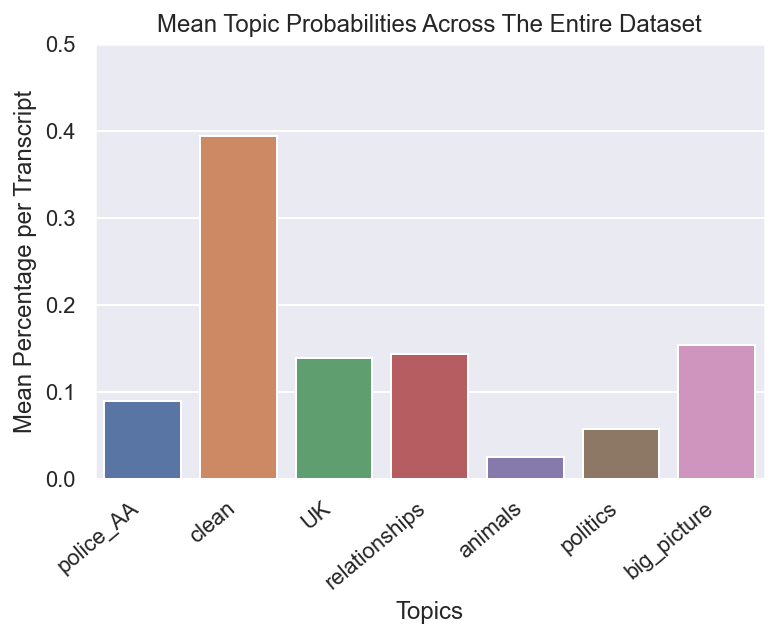

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
%config InlineBackend.figure_formats = ['retina']

topics = ['police_AA', 'clean', 'UK', 'relationships', 'animals', 'politics', 'big_picture']
ax = sns.barplot(x=df[topics].mean().index, y=df[topics].loc[df.rating_type == 1].mean())
ax.set_xticklabels(topics, rotation=40, ha='right')
ax.set_title('Mean Topic Probabilities Across The Entire Dataset')
ax.set(xlabel='Topics', ylabel='Mean Percentage per Transcript', ylim=(0, 0.5))

In [4]:
# Prepare X
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = df[topics]
X = StandardScaler().fit_transform(X)
X.shape

(322, 7)

In [5]:
# Cluster X with differnt n's. Score with silhouette metric
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

temp_dict = {}
inertias = []
for n_clusters in range(2,15):
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    temp_dict[n_clusters] = [silhouette_avg] 
    
    inertia = clusterer.inertia_
    print("\tThe inertia is :", inertia)
    inertias.append(inertia)

For n_clusters = 2 The average silhouette_score is : 0.2940689579296579
	The inertia is : 1851.9688639920282
For n_clusters = 3 The average silhouette_score is : 0.3291608640763763
	The inertia is : 1561.1776810575295
For n_clusters = 4 The average silhouette_score is : 0.3663068372649058
	The inertia is : 1272.6470135120685
For n_clusters = 5 The average silhouette_score is : 0.456272128243425
	The inertia is : 979.2163197068556
For n_clusters = 6 The average silhouette_score is : 0.4540098104957834
	The inertia is : 681.8413233533142
For n_clusters = 7 The average silhouette_score is : 0.5137048074169653
	The inertia is : 437.23403130355655
For n_clusters = 8 The average silhouette_score is : 0.42319664545404634
	The inertia is : 384.55626416655775
For n_clusters = 9 The average silhouette_score is : 0.41470844805891427
	The inertia is : 346.5905590939923
For n_clusters = 10 The average silhouette_score is : 0.4244618724470583
	The inertia is : 316.6669136448169
For n_clusters = 11 T

Text(0.5, 0, 'Clusters')

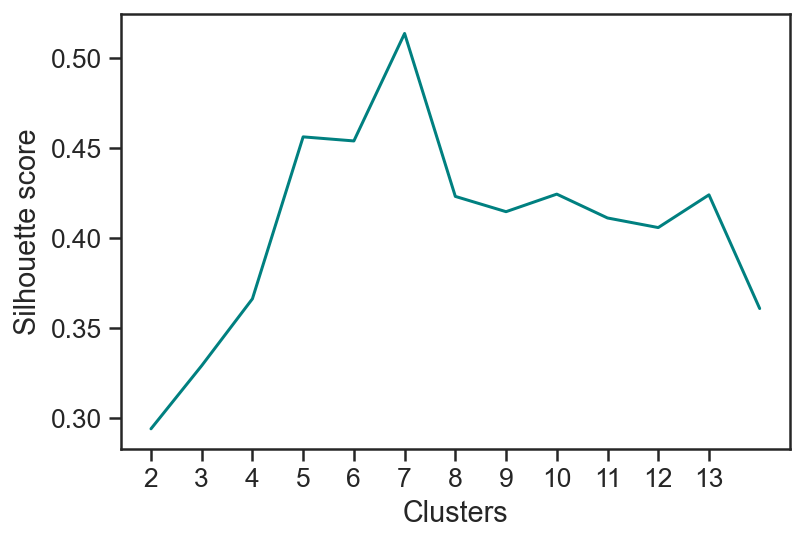

In [6]:
sns.set(font_scale=1.2)
sns.set_style('ticks')
s_scores = pd.DataFrame(temp_dict).T
ax = sns.lineplot(x=s_scores.index, y=s_scores[0], color='teal')
# ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks(range(2,14))
ax.set_ylabel('Silhouette score')
ax.set_xlabel('Clusters')
# ax.figure.tight_layout()
# ax.figure.savefig('./images/LDAsilhouette.png', dpi=200)

Text(0.5, 0, 'Clusters')

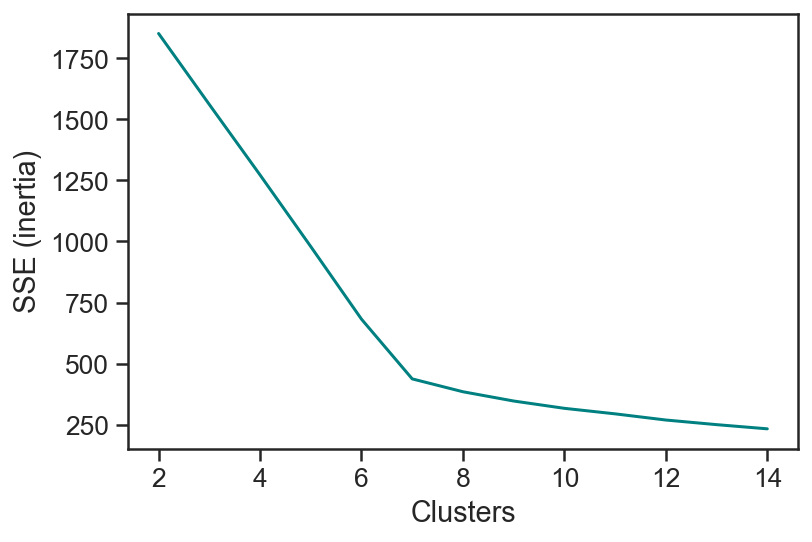

In [7]:
ax = sns.lineplot(range(2,15), inertias, color='teal')
ax.set_ylabel('SSE (inertia)')
ax.set_xlabel('Clusters')
# ax.figure.tight_layout()
# ax.figure.savefig('./images/LDAelbow.png', dpi=200)

In [8]:
clusterer = KMeans(n_clusters=7, random_state=10)
df['cluster_LDA'] = clusterer.fit_predict(X)

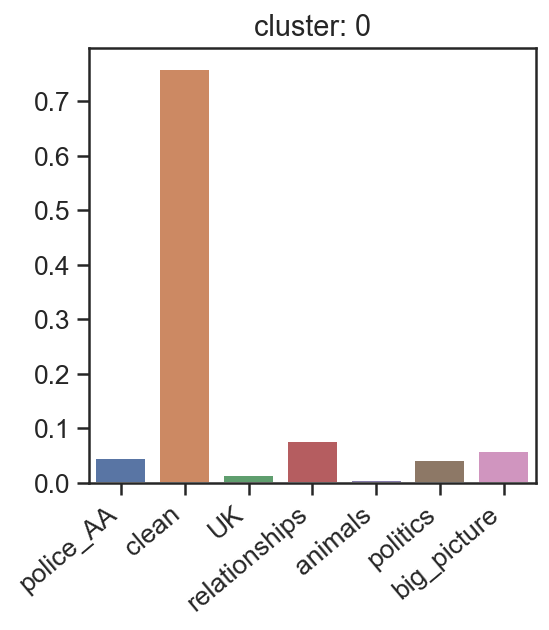

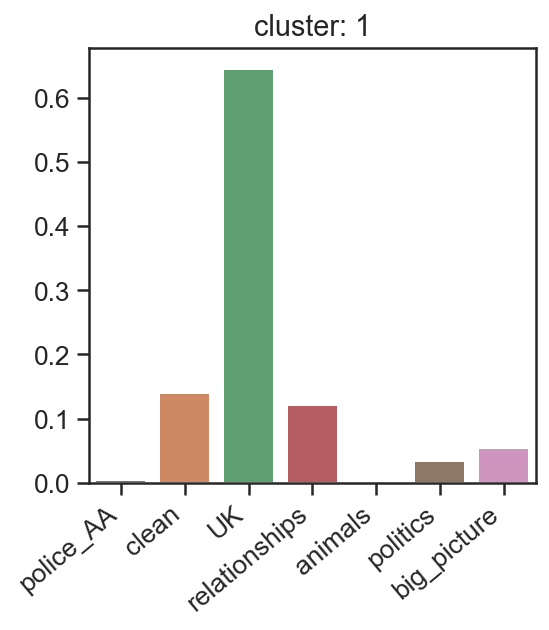

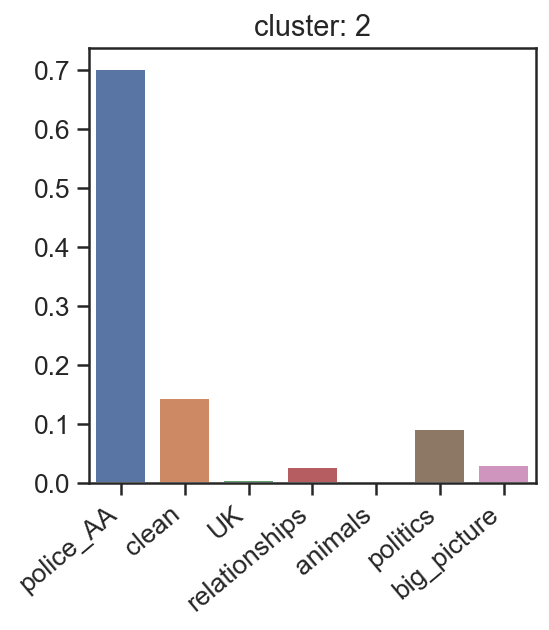

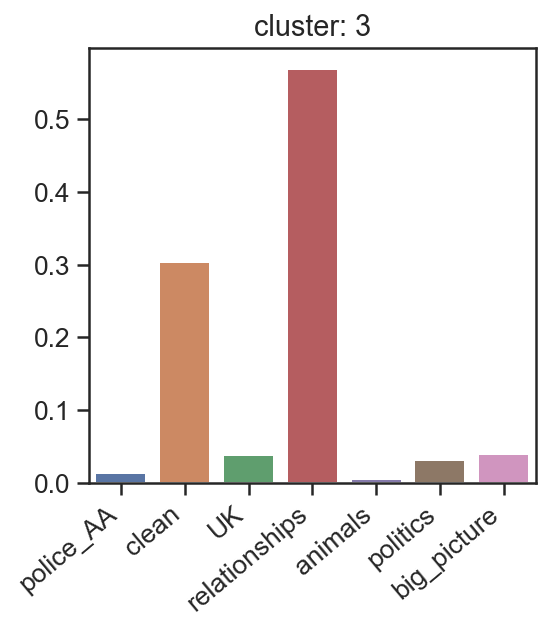

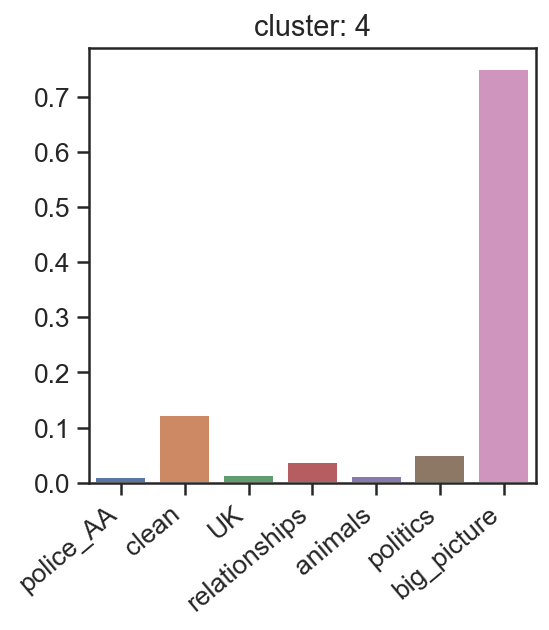

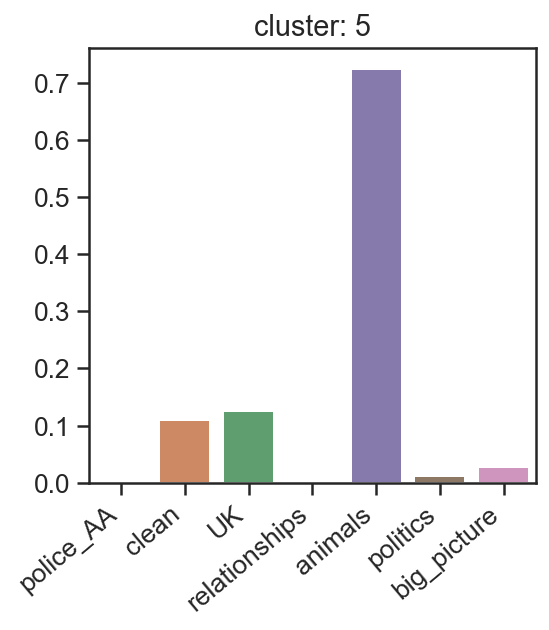

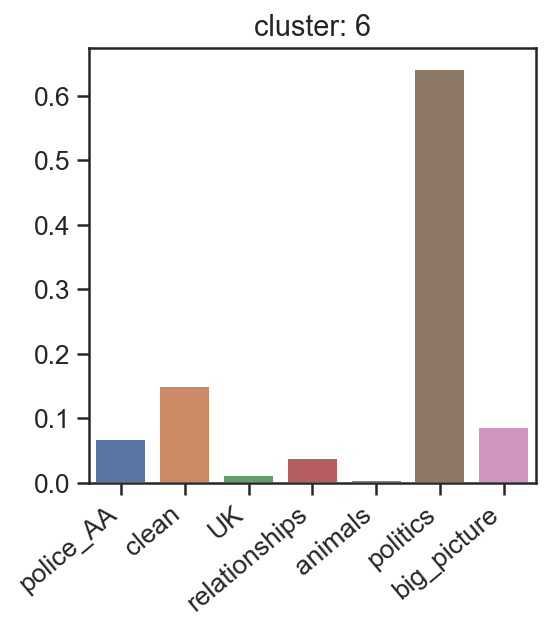

In [9]:
for cluster in range(7):
    # Create a subplot with 1 row and 1 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)
     
    ax = sns.barplot(x=df[topics].mean().index, y=df[topics].loc[df.cluster_LDA == cluster].mean())
    ax.set_xticklabels(topics, rotation=40, ha='right')   
    ax.set_title(f'cluster: {cluster}')

In [10]:
df.cluster_LDA.value_counts()

0    144
3     45
1     35
6     33
4     30
2     30
5      5
Name: cluster_LDA, dtype: int64

In [11]:
# Clean text (get tri- and bi-grams, lemmatize, and take only selected POS)
from gensim.models import Phrases
from gensim.models.phrases import Phraser 
import spacy

# Build bigram and trigram Phrases objects
bigram_phrases = Phrases(df.words[:], min_count=10)
trigram_phrases = Phrases(bigram_phrases[df.words[:]], min_count=5)

# Create Phraser model object for faster processing by passing in the Phrases object (Gensim has a confusing API...)
bigram_model = Phraser(bigram_phrases)
trigram_model = Phraser(trigram_phrases)

trigrams = [trigram_model[bigram_model[word]] for word in df.words]

nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN','ADJ','VERB','ADV']
lemmatized_words = []
for sent in trigrams:
    doc = nlp(" ".join(sent))
    lemmatized_words.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

In [12]:
# Prepare for KMeans clustering using Tfidf matrix
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, 
                        lowercase=False,
                        min_df = 10,
                        max_df = 0.4,)   

X = tfidf.fit_transform(lemmatized_words)
X.shape

(322, 4073)

In [13]:
# Cluster X with differnt n's. Score with silhouette metric
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

temp_dict = {}
inertias = []
for n_clusters in range(2,40):
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    temp_dict[n_clusters] = [silhouette_avg] 
    
    inertia = clusterer.inertia_
    print("\tThe inertia is :", inertia)
    inertias.append(inertia)

For n_clusters = 2 The average silhouette_score is : 0.005536359702423147
	The inertia is : 292.14424749007213
For n_clusters = 3 The average silhouette_score is : 0.005693518666617985
	The inertia is : 289.0279099966101
For n_clusters = 4 The average silhouette_score is : 0.006559894519880124
	The inertia is : 287.27652875273316
For n_clusters = 5 The average silhouette_score is : 0.004726959081233155
	The inertia is : 286.6011327992689
For n_clusters = 6 The average silhouette_score is : 0.004931214317913211
	The inertia is : 284.8609845102485
For n_clusters = 7 The average silhouette_score is : 0.005697911919990711
	The inertia is : 283.5595189140414
For n_clusters = 8 The average silhouette_score is : 0.008110915242889325
	The inertia is : 281.6838187855603
For n_clusters = 9 The average silhouette_score is : 0.007850755957301147
	The inertia is : 280.4041396351565
For n_clusters = 10 The average silhouette_score is : 0.011415742518625779
	The inertia is : 278.9946367303079
For n_c

Text(0.5, 0, 'Clusters')

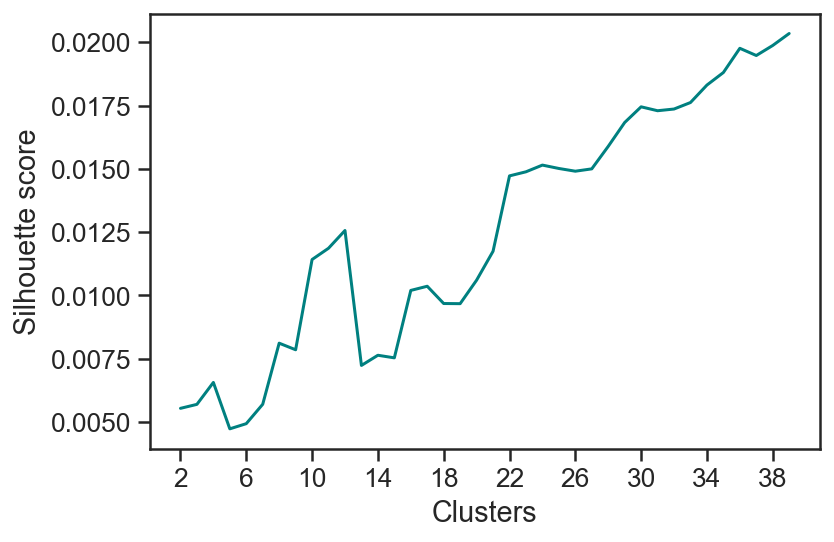

In [14]:
s_scores = pd.DataFrame(temp_dict).T
ax = sns.lineplot(x=s_scores.index, y=s_scores[0], color='teal')
# ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks(range(2,40, 4))
ax.set_ylabel('Silhouette score')
ax.set_xlabel('Clusters')
# ax.figure.tight_layout()
# ax.figure.savefig('./images/TFIDFSilouhette.png', dpi=200)

Text(0.5, 0, 'Clusters')

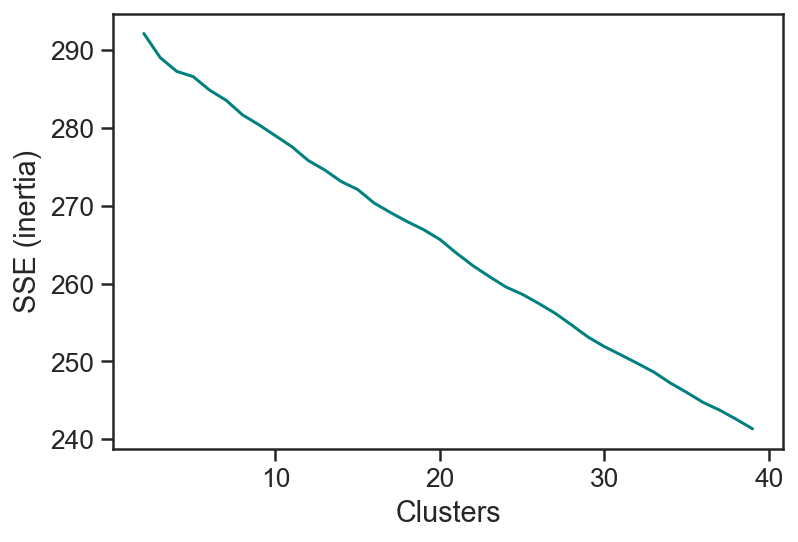

In [15]:
ax = sns.lineplot(range(2,40), inertias, color='teal')
ax.set_ylabel('SSE (inertia)')
ax.set_xlabel('Clusters')
# ax.figure.tight_layout()
# ax.figure.savefig('./images/TFIDFelbow.png', dpi=200)

In [16]:
clusterer = KMeans(n_clusters=7, random_state=10)
df['cluster_tfidf'] = clusterer.fit_predict(X)

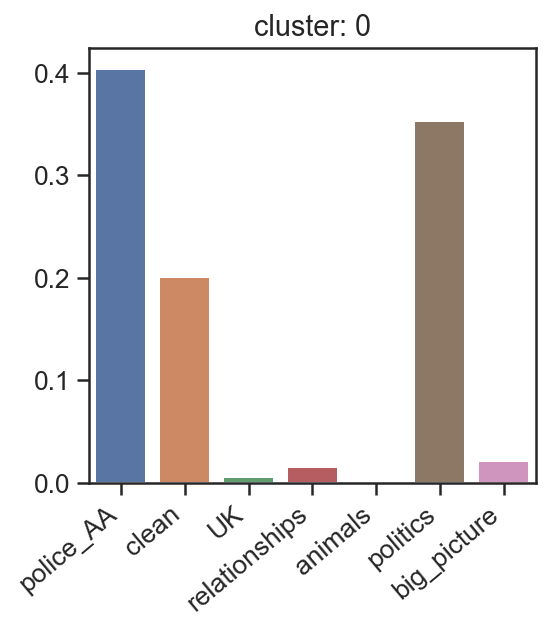

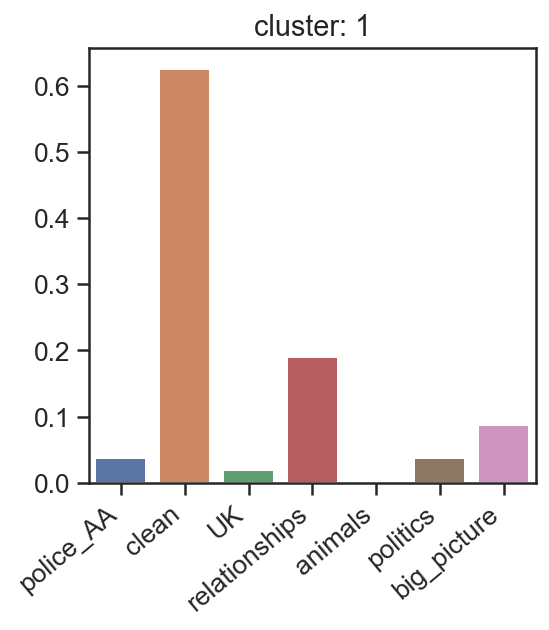

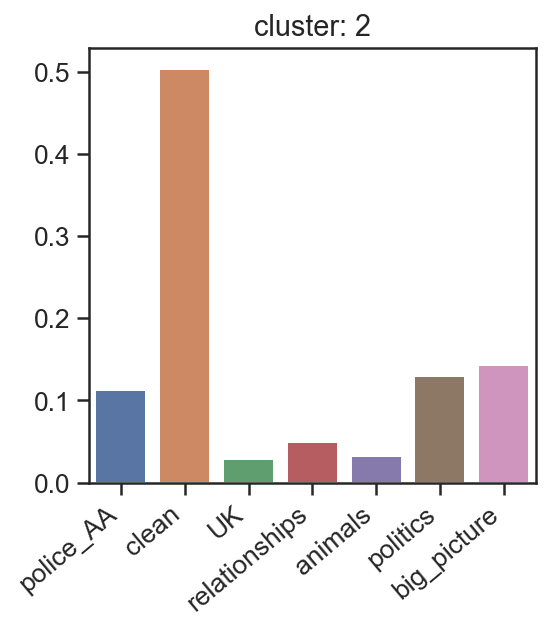

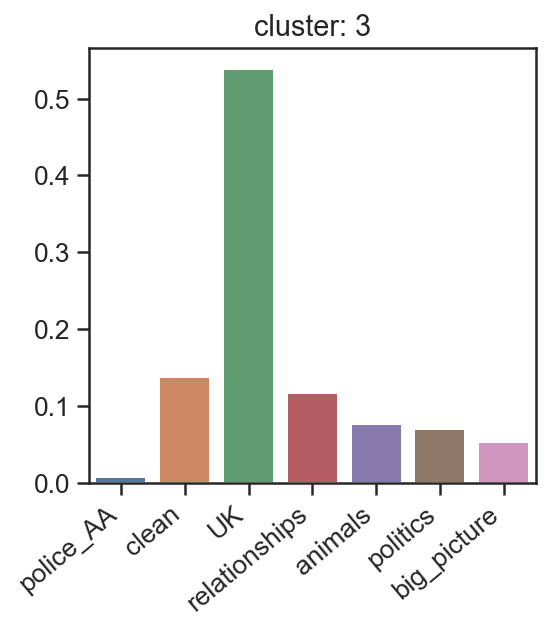

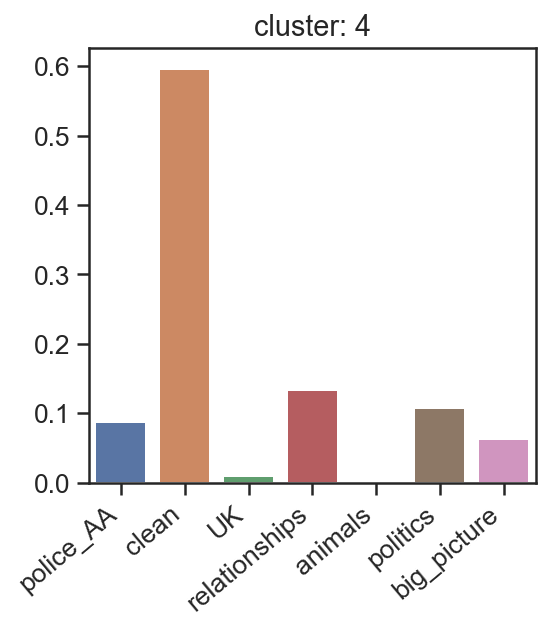

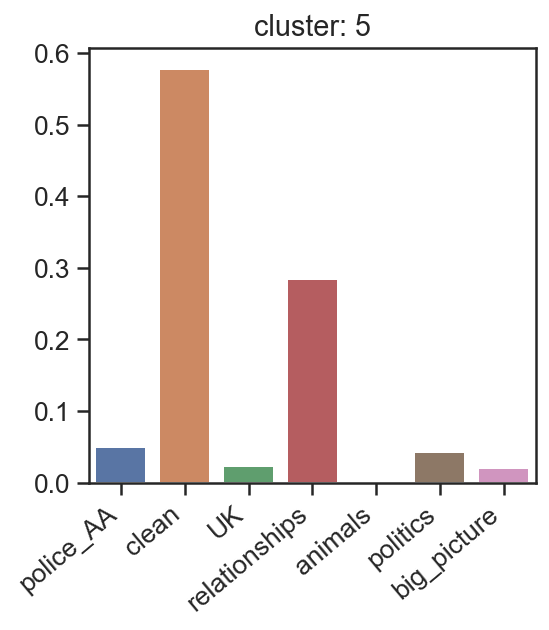

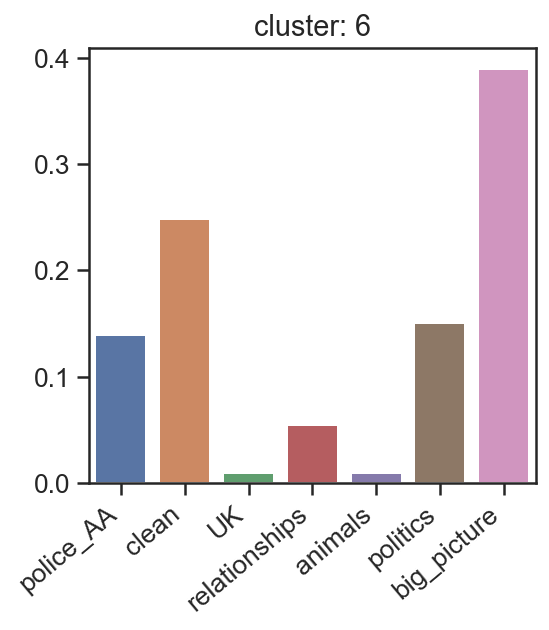

In [17]:
for cluster in range(7):
    # Create a subplot with 1 row and 1 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)
    
    ax = sns.barplot(x=df[topics].mean().index, y=df[topics].loc[df.cluster_tfidf == cluster].mean())
    ax.set_xticklabels(topics, rotation=40, ha='right')   
    ax.set_title(f'cluster: {cluster}')

In [18]:
df.cluster_tfidf.value_counts()

1    68
6    55
4    54
5    49
3    44
2    27
0    25
Name: cluster_tfidf, dtype: int64

In [19]:
df.head()

,title,date_posted,link,name,year,transcript,language,runtime,rating,rating_type,...,diversity_ratio,police_AA,clean,UK,relationships,animals,politics,big_picture,cluster_LDA,cluster_tfidf
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020.0,"NARRATOR: Ladies and gentlemen, it’s start t...",en,67.0,6.1,0,...,0.244844,0.014837,0.468094,0.000491,0.218316,0.000475,0.246499,0.051288,0,2
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020.0,"ANNOUNCER: Ladies and gentlemen, welcome to th...",en,NaN,NaN,0,...,0.300851,0.160739,0.536182,0.000526,0.135120,0.000513,0.144745,0.022175,0,5
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012.0,"L.A., are you ready? Live from the Alex Thea...",en,59.0,7.8,1,...,0.278128,0.338921,0.529810,0.000956,0.127428,0.000929,0.000967,0.000989,0,4
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010.0,This programme contains strong language Over ...,en,60.0,7.2,0,...,0.356930,0.000455,0.069649,0.840645,0.000443,0.000422,0.000438,0.087947,1,3
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,"PRESENTER: Ladies and gentlemen, please welco...",en,68.0,7.7,1,...,0.313244,0.012360,0.151348,0.833839,0.000795,0.000339,0.000353,0.000966,1,3


In [20]:
# # Pickle DataFrame
# df.to_pickle('./data/stand-up-data-w-clusters.pkl')